In [5]:
from google.colab import drive, files, auth
drive.mount("/content/gdrive", force_remount=True)


Mounted at /content/gdrive


In [0]:
from fastai import *
from fastai.vision import *


In [9]:
cd gdrive/My Drive/segmentation

/content/gdrive/My Drive/segmentation


In [11]:
!unzip SegNet-Tutorial-master.zip

Archive:  SegNet-Tutorial-master.zip
bb68b64e72cb004b3ed927fee0f5624dd8097498
   creating: SegNet-Tutorial-master/
  inflating: SegNet-Tutorial-master/.gitattributes  
 extracting: SegNet-Tutorial-master/.gitignore  
   creating: SegNet-Tutorial-master/CamVid/
  inflating: SegNet-Tutorial-master/CamVid/test.txt  
   creating: SegNet-Tutorial-master/CamVid/test/
 extracting: SegNet-Tutorial-master/CamVid/test/0001TP_008550.png  
 extracting: SegNet-Tutorial-master/CamVid/test/0001TP_008580.png  
 extracting: SegNet-Tutorial-master/CamVid/test/0001TP_008610.png  
 extracting: SegNet-Tutorial-master/CamVid/test/0001TP_008640.png  
  inflating: SegNet-Tutorial-master/CamVid/test/0001TP_008670.png  
 extracting: SegNet-Tutorial-master/CamVid/test/0001TP_008700.png  
 extracting: SegNet-Tutorial-master/CamVid/test/0001TP_008730.png  
 extracting: SegNet-Tutorial-master/CamVid/test/0001TP_008760.png  
 extracting: SegNet-Tutorial-master/CamVid/test/0001TP_008790.png  
 extracting: SegNet-Tuto

In [0]:
path=Path('./CamVid/')

In [19]:
path.ls()

[PosixPath('CamVid/test.txt'),
 PosixPath('CamVid/test'),
 PosixPath('CamVid/testannot'),
 PosixPath('CamVid/train.txt'),
 PosixPath('CamVid/train'),
 PosixPath('CamVid/trainannot'),
 PosixPath('CamVid/val.txt'),
 PosixPath('CamVid/val'),
 PosixPath('CamVid/valannot')]

In [20]:
fnames=get_image_files(path/'val')
fnames[:3]

[PosixPath('CamVid/val/0016E5_07959.png'),
 PosixPath('CamVid/val/0016E5_07961.png'),
 PosixPath('CamVid/val/0016E5_07963.png')]

In [22]:
lbl_names=get_image_files(path/'valannot')
lbl_names[:3]

[PosixPath('CamVid/valannot/0016E5_07959.png'),
 PosixPath('CamVid/valannot/0016E5_07961.png'),
 PosixPath('CamVid/valannot/0016E5_07963.png')]

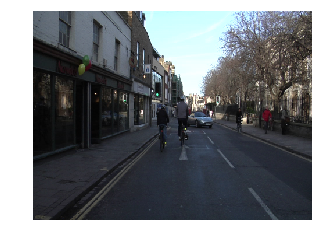

In [27]:
img_f=fnames[10]
img=open_image(img_f)
img.show(figsize=(5,5))

In [0]:
def get_y_fn(x):
    return Path(str(x.parent)+'annot')/x.name

codes=array(['Sky','Building','Pole','Road','Sidewalk','Tree','Sign',
             'Fence','Car','Pedestrian','Cyclist','Void'])

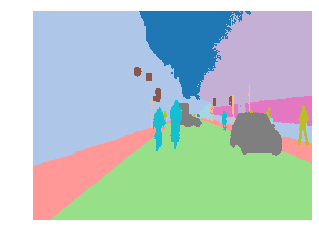

In [25]:
mask=open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5),alpha=1.)

In [31]:
src_size=np.array(mask.shape[1:])
src_size,mask.data

(array([360, 480]), tensor([[[1, 1, 1,  ..., 5, 5, 5],
          [1, 1, 1,  ..., 5, 5, 5],
          [1, 1, 1,  ..., 5, 5, 5],
          ...,
          [4, 4, 4,  ..., 3, 3, 3],
          [4, 4, 4,  ..., 3, 3, 3],
          [4, 4, 4,  ..., 3, 3, 3]]]))

**Datasets**

In [0]:
bs,size=8,src_size//2

In [0]:
data=(SegmentationItemList.from_folder(path)
    .split_by_folder(valid='val')
    .label_from_func(get_y_fn,classes=codes)
    .transform(get_transforms(),tfm_y=True)
    .databunch(bs=bs)
    .normalize(imagenet_stats))

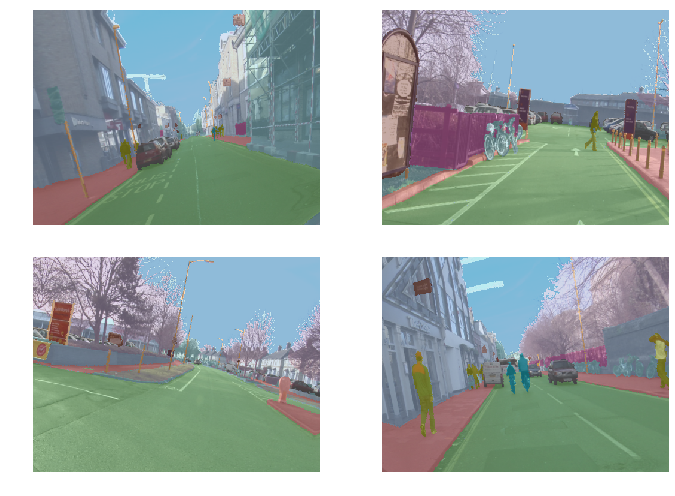

In [36]:
data.show_batch(2,figsize=(10,7))

**Model**

In [0]:
name2id={v:k for k,v in enumerate(codes)}
void_code=name2id['Void']

def acc_camvid(input,target):
    target=target.squeeze(1)
    mask=target !=void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [41]:
name2id,void_code

({'Building': 1,
  'Car': 8,
  'Cyclist': 10,
  'Fence': 7,
  'Pedestrian': 9,
  'Pole': 2,
  'Road': 3,
  'Sidewalk': 4,
  'Sign': 6,
  'Sky': 0,
  'Tree': 5,
  'Void': 11},
 11)

In [0]:
metrics=acc_camvid
wd=1e-2

In [43]:
learn=unet_learner(data,models.resnet34,metrics=metrics,wd=wd,bottle=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 159434739.13it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


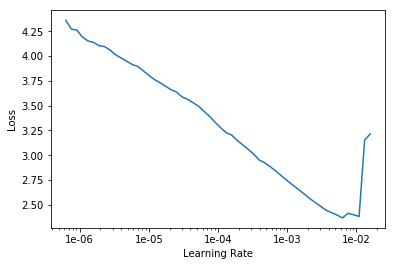

In [44]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=2e-3

In [46]:
learn.fit_one_cycle(10,slice(lr),pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.284072,0.886099,0.765885,00:50
1,0.846195,0.581171,0.847879,00:47
2,0.638751,0.484274,0.837984,00:48
3,0.555667,0.458281,0.870961,00:49
4,0.524964,0.508019,0.865269,00:49
5,0.486698,0.453388,0.866704,00:49
6,0.426291,0.420033,0.861213,00:49
7,0.441188,0.413896,0.880278,00:49
8,0.424685,0.331635,0.891766,00:49
9,0.361059,0.302148,0.899346,00:49


In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1');

In [0]:
learn.unfreeze()

In [0]:
lrs=slice(lr/100,lr)

In [51]:
learn.fit_one_cycle(12,lrs,pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.294595,0.286707,0.908846,00:49
1,0.279438,0.287236,0.915157,00:50
2,0.271077,0.288760,0.913776,00:50
3,0.274334,0.303939,0.902893,00:51
4,0.281273,0.424288,0.886335,00:52
5,0.304135,0.373843,0.892442,00:51
6,0.312499,0.446445,0.861458,00:51
7,0.297883,0.305853,0.904371,00:51
8,0.308719,0.350885,0.900766,00:51
9,0.294839,0.301416,0.918444,00:51


In [0]:
learn.save('stage-2')

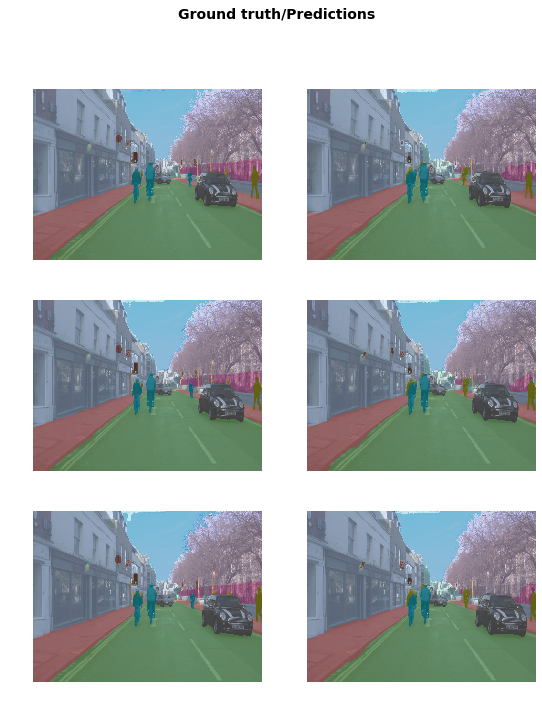

In [54]:
learn.show_results(rows=3,figsize=(9,11))